In [41]:
import argparse
import gzip
import os
import sys

import pandas as pd
import numpy as np

# -------------------- Visualization Libraries ---------------------
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
import matplotlib.ticker as mtick
from matplotlib.offsetbox import AnchoredText
import matplotlib.colors as clr
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn
from matplotlib_venn import venn2, venn2_circles

# -------------------- Matplotlib Configuration --------------------
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica Neue'

# Dynamically add src directory to sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_path = os.path.join(project_root, 'src')
sys.path.insert(0, src_path)

from quality_control import CheckLibRecoveryRate


In [5]:
# Set the project root directory (assuming current working directory is within a subdirectory)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))


In [6]:
# Global list to collect all library recovery DataFrames from different experiments.
recovery_dataframes = []

def process_experiment(file_relative_path, dna_rep_count, rna_rep_count, experiment_label):
    """
    Process a single experiment by calculating library recovery metrics.
    
    Parameters:
        file_relative_path (str): Relative path from the project root to the count matrix file.
        dna_rep_count (int): Number of DNA replicates for the experiment.
        rna_rep_count (int): Number of RNA replicates for the experiment.
        experiment_label (str): A descriptive label for the experiment.
    
    Process:
        1. Construct the full file path from the project root.
        2. (Assumption) The function CheckLibRecoveryRate uses the file defined by the experiment path internally.
        3. Call CheckLibRecoveryRate to retrieve total counts, sequenced counts, and fragment count.
        4. Calculate the sequencing coverage metric using qc.calc_sequencing_coverage.
        5. Append a new column with the experiment label to the resulting DataFrame.
        6. Add the resulting DataFrame to the global recovery_dataframes list.
    """
    # Construct the full path to the count matrix file.
    experiment_file_path = os.path.join(project_root, file_relative_path)
    
    # Instantiate the CheckLibRecoveryRate object with the provided replicate counts.
    qc = CheckLibRecoveryRate(dna_rep_count, rna_rep_count)
    
    # Retrieve metrics from the count matrix file:
    # total_counts, sequenced_counts, and fragment_count are obtained by passing the file path.
    total_counts, sequenced_counts, fragment_count = qc.get_stats_from_count_mat(experiment_file_path)
    
    # Calculate the sequencing coverage metric using the obtained fragment and sequenced counts.
    recovery_df = qc.calc_sequencing_coverage(fragment_count, sequenced_counts)
    
    # Label the resulting DataFrame with the provided experiment description.
    recovery_df['data'] = experiment_label
    
    # Append the DataFrame to the global list of recovery metrics.
    recovery_dataframes.append(recovery_df)
    

In [9]:
# -------------------------
# Process Experiments
# -------------------------

# WHG-STARR-seq

process_experiment(
    'data/count_data/WHG_STARR_seq/count_mat_original_frag_sorted.bed',
    dna_rep_count=1, rna_rep_count=3,
    experiment_label='WHG-STARR-seq (original_frag)'
)

process_experiment(
    'data/count_data/WHG_STARR_seq/count_mat_genomic_bin_100bp_stepSize_10bp_sorted.bed',
    dna_rep_count=1, rna_rep_count=3,
    experiment_label='WHG-STARR-seq (genomic_bins)'
)


In [ ]:
# ATAC-STARR-seq Experiments
process_experiment(
    'data/count_data/ATAC_STARR_seq/count_mat_original_frag_sorted.bed',
    dna_rep_count=6, rna_rep_count=4,
    experiment_label='ATAC-STARR-seq (original_frag)'
)
process_experiment(
    'data/count_data/ATAC_STARR_seq/count_mat_original_frag_ATAC_seq_Peak_region.bed',
    dna_rep_count=6, rna_rep_count=4,
    experiment_label='ATAC-STARR-seq (original_frag in ATAC_peaks)'
)
process_experiment(
    'data/count_data/ATAC_STARR_seq/count_mat_genomic_bin_100bp_stepSize_10bp_sorted.bed',
    dna_rep_count=6, rna_rep_count=4,
    experiment_label='ATAC-STARR-seq (genomic_bins)'
)
process_experiment(
    'data/count_data/ATAC_STARR_seq/count_mat_genomic_bin_100bp_stepSize_10bp_ATAC_seq_Peak_region.bed',
    dna_rep_count=6, rna_rep_count=4,
    experiment_label='ATAC-STARR-seq (genomic_bins in ATAC_peaks)'
)


In [7]:
# LentiMPRA Experiment
process_experiment(
    'data/count_data/LentiMPRA/UMI_count_with_all_annotation.txt',
    dna_rep_count=3, rna_rep_count=3,
    experiment_label='LentiMPRA'
)

# TilingMPRA Experiments
process_experiment(
    'data/count_data/TilingMPRA/OL13_ENCSR394HXI/processed_OL13_count_with_all_annotation.txt',
    dna_rep_count=4, rna_rep_count=4,
    experiment_label='TilingMPRA (ENCSR394HXI)'
)
process_experiment(
    'data/count_data/TilingMPRA/OL43_ENCSR917SFD/processed_OL43_count_with_all_annotation.txt',
    dna_rep_count=5, rna_rep_count=5,
    experiment_label='TilingMPRA (ENCSR917SFD)'
)
process_experiment(
    'data/count_data/TilingMPRA/OL45_ENCSR363XER/processed_OL45_count_with_all_annotation.txt',
    dna_rep_count=5, rna_rep_count=4,
    experiment_label='TilingMPRA (ENCSR363XER)'
)


In [16]:
# -------------------------
# Combine and Output Final Results
# -------------------------
# Concatenate all individual recovery DataFrames into one master DataFrame.
final_recovery_df = pd.concat(recovery_dataframes, ignore_index=True)

# Display the first few rows of the combined DataFrame.
print(final_recovery_df.head())

# Optionally, save the final results to a file.
output_file = os.path.join(project_root, 'data', 'output', 'combined_lib_recovery_metrics.txt')
final_recovery_df.to_csv(output_file, sep='\t', index=False)


  library   total  num_sequenced        pct       data
0    DNA1  233104         232847  99.889749  LentiMPRA
1    DNA2  233104         232337  99.670962  LentiMPRA
2    DNA3  233104         232730  99.839557  LentiMPRA
3    RNA1  233104         233016  99.962249  LentiMPRA
4    RNA2  233104         232898  99.911627  LentiMPRA


In [42]:

# Define a color palette mapping for the DNA and RNA categories.
color_palette = {'DNA': '#ffd6e0', 'RNA': '#bde0fe'}

def create_barplot(ax, x_col, y_col, plot_data, hue_col, hue_order, x_order, color_palette,
                   dataset_name, ytick_labels, show_legend=False, hide_x_axis=False):
    """
    Create a horizontal barplot on a provided Axes object with custom styling and annotations.

    Parameters:
        ax (matplotlib.axes.Axes): Axes object to plot on.
        x_col (str): Column name for x-axis values.
        y_col (str): Column name for y-axis values.
        plot_data (pd.DataFrame): DataFrame containing the data to be plotted.
        hue_col (str): Column name used for color encoding.
        hue_order (list): Order for the hue categorical variable.
        x_order (list): Order for the x-axis categorical variable.
        color_palette (dict): Mapping from hue categories to colors.
        dataset_name (str): Dataset label to annotate the subplot.
        ytick_labels (list): List of labels for the y-axis ticks.
        show_legend (bool): Flag indicating whether to display the legend.
        hide_x_axis (bool): Flag to hide x-axis tick labels and ticks.
    
    Returns:
        ax (matplotlib.axes.Axes): The modified Axes object with the barplot.
    """
    # Create a horizontal barplot with standard deviation error bars.
    ax = sns.barplot(
        x=x_col, y=y_col, data=plot_data, hue=hue_col, hue_order=hue_order,
        order=x_order, palette=color_palette, orient='h',
        errorbar='sd', err_kws={'color': '#343a40', 'linewidth': 0.8},
        capsize=0.2, legend=False
    )
    
    # Draw a vertical dashed line at x = 100 as a reference marker.
    ax.axvline(x=100, color='#b5c6e0', linestyle='--')
    
    # Set the x-axis limits.
    ax.set_xlim([0, 105])
    # Update y-tick labels and styling.
    ax.set_yticklabels(ytick_labels, fontsize=15)
    ax.set_ylabel('', fontsize=17)
    
    # Get the y-axis transformation (for annotation positioning).
    y_axis_transform = ax.get_yaxis_transform()
    
    # Annotate the subplot with the dataset name at an appropriate position.
    if dataset_name == 'TilingMPRA':
        ax.annotate(dataset_name, xy=(-0.6, 1), xycoords=y_axis_transform,
                    ha="center", va="center", fontsize=17, rotation=90)
    elif dataset_name == 'ATAC-STARR-seq':
        ax.annotate(dataset_name, xy=(-0.6, 1.5), xycoords=y_axis_transform,
                    ha="center", va="center", fontsize=17, rotation=90)
    elif dataset_name == 'WHG-STARR-seq':
        ax.annotate(dataset_name, xy=(-0.6, 0.5), xycoords=y_axis_transform,
                    ha="center", va="center", fontsize=17, rotation=90)
    else:
        ax.set_ylabel('', fontsize=17)
        
    # Configure x-axis appearance.
    if hide_x_axis:
        ax.xaxis.set_tick_params(bottom=False, labelbottom=False)
        ax.minorticks_off()
        ax.set_xlabel('', fontsize=20)
        sns.despine(ax=ax, top=True, right=True, left=False, bottom=True)
    else:
        ax.set_xticks([0, 20, 40, 60, 80, 100])
        ax.set_xticklabels([0, 20, 40, 60, 80, 100], fontsize=15)
        ax.set_xlabel('Library Recovery (%)', fontsize=17)
        sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)
        
    # Optionally add a legend.
    if show_legend:
        legend_handles = [
            mpatches.Patch(color=color_palette['DNA'], label='DNA'),
            mpatches.Patch(color=color_palette['RNA'], label='RNA')
        ]
        plt.legend(legend_handles, bbox_to_anchor=(0.95, -0.4),
                   fancybox=True, borderaxespad=0., fontsize=17, ncol=2)
    
    return ax



In [37]:
# Add an annotation column to indicate library type (DNA or RNA)

final_recovery_df['annot'] = 'DNA'
final_recovery_df.loc[final_recovery_df[final_recovery_df['library'].map(lambda x: 'RNA' in x)].index.tolist(), 'annot'] = 'RNA'

print(final_recovery_df.groupby(['annot']).size())

final_recovery_df.head()


annot
DNA    43
RNA    38
dtype: int64


,library,total,num_sequenced,pct,data,annot
0,DNA1,233104,232847,99.889749,LentiMPRA,DNA
1,DNA2,233104,232337,99.670962,LentiMPRA,DNA
2,DNA3,233104,232730,99.839557,LentiMPRA,DNA
3,RNA1,233104,233016,99.962249,LentiMPRA,RNA
4,RNA2,233104,232898,99.911627,LentiMPRA,RNA


In [39]:
print(final_recovery_df.groupby(['data']).size())


data
ATAC-STARR-seq (genomic_bins in ATAC_peaks)     10
ATAC-STARR-seq (genomic_bins)                   10
ATAC-STARR-seq (original_frag in ATAC_peaks)    10
ATAC-STARR-seq (original_frag)                  10
LentiMPRA                                        6
TilingMPRA (ENCSR363XER)                         9
TilingMPRA (ENCSR394HXI)                         8
TilingMPRA (ENCSR917SFD)                        10
WHG-STARR-seq (genomic_bins)                     4
WHG-STARR-seq (original_frag)                    4
dtype: int64


<ipython-input-42-0a2befb01a48>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ytick_labels, fontsize=15)
<ipython-input-42-0a2befb01a48>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ytick_labels, fontsize=15)
<ipython-input-42-0a2befb01a48>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ytick_labels, fontsize=15)
<ipython-input-42-0a2befb01a48>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ytick_labels, fontsize=15)


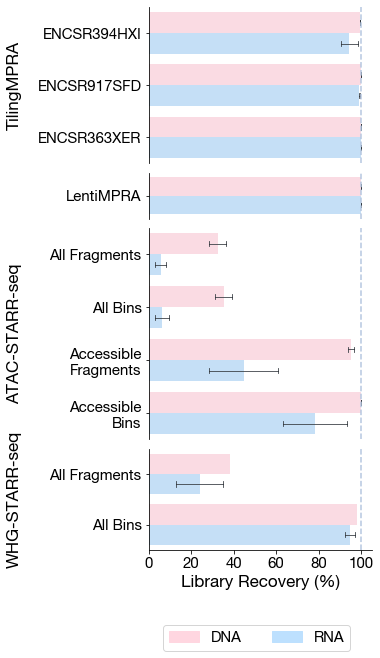

In [48]:
# Define column names for plotting.
x_col = 'pct'
y_col = 'data'
hue_col = 'annot'
hue_order = ['DNA', 'RNA']

# Create a figure for the composite plot.
fig = plt.figure(figsize=(4, 11))
plt.subplots_adjust(hspace=0.2)

# -------------------------------
# Subplot 1: TilingMPRA Data
# -------------------------------
ax_tiling = plt.subplot2grid((11, 1), (0, 0), rowspan=3)
tiling_x_order = ['TilingMPRA (ENCSR394HXI)', 'TilingMPRA (ENCSR917SFD)', 'TilingMPRA (ENCSR363XER)']
tiling_ytick_labels = ['ENCSR394HXI', 'ENCSR917SFD', 'ENCSR363XER']
tiling_dataset_name = 'TilingMPRA'
tiling_data = final_recovery_df[final_recovery_df['data'].map(lambda x: 'TilingMPRA' in x)]
ax_tiling = create_barplot(
    ax=ax_tiling, x_col=x_col, y_col=y_col, plot_data=tiling_data,
    hue_col=hue_col, hue_order=hue_order, x_order=tiling_x_order,
    color_palette=color_palette, dataset_name=tiling_dataset_name,
    ytick_labels=tiling_ytick_labels, show_legend=False, hide_x_axis=True
)

# -------------------------------
# Subplot 2: LentiMPRA Data
# -------------------------------
ax_lenti = plt.subplot2grid((11, 1), (3, 0), rowspan=1, sharex=ax_tiling)
lenti_x_order = ['LentiMPRA']
lenti_ytick_labels = ['LentiMPRA']
lenti_dataset_name = 'LentiMPRA'
lenti_data = final_recovery_df[final_recovery_df['data'].map(lambda x: 'LentiMPRA' in x)]
ax_lenti = create_barplot(
    ax=ax_lenti, x_col=x_col, y_col=y_col, plot_data=lenti_data,
    hue_col=hue_col, hue_order=hue_order, x_order=lenti_x_order,
    color_palette=color_palette, dataset_name=lenti_dataset_name,
    ytick_labels=lenti_ytick_labels, show_legend=False, hide_x_axis=True
)

# -------------------------------
# Subplot 3: ATAC-STARR-seq Data
# -------------------------------
ax_atac = plt.subplot2grid((11, 1), (4, 0), rowspan=4, sharex=ax_tiling)
# atac_x_order = ['All Fragments', 'All Bins', 'Accessible\nFragments', 'Accessible\nBins']
atac_x_order = ['ATAC-STARR-seq (original_frag)', 'ATAC-STARR-seq (original_frag in ATAC_peaks)', 
                'ATAC-STARR-seq (genomic_bins)', 'ATAC-STARR-seq (genomic_bins in ATAC_peaks)']
atac_ytick_labels = ['All Fragments', 'All Bins', 'Accessible\nFragments', 'Accessible\nBins']
atac_dataset_name = 'ATAC-STARR-seq'
atac_data = final_recovery_df[final_recovery_df['data'].map(lambda x: 'ATAC-STARR-seq' in x)]
ax_atac = create_barplot(
    ax=ax_atac, x_col=x_col, y_col=y_col, plot_data=atac_data,
    hue_col=hue_col, hue_order=hue_order, x_order=atac_x_order,
    color_palette=color_palette, dataset_name=atac_dataset_name,
    ytick_labels=atac_ytick_labels, show_legend=False, hide_x_axis=True
)

# -------------------------------
# Subplot 4: WHG-STARR-seq Data
# -------------------------------
ax_whg = plt.subplot2grid((11, 1), (8, 0), rowspan=2, sharex=ax_tiling)
# whg_x_order = ['All Fragments', 'All Bins']
whg_x_order = ['WHG-STARR-seq (original_frag)', 'WHG-STARR-seq (genomic_bins)']
whg_ytick_labels = ['All Fragments', 'All Bins']
whg_dataset_name = 'WHG-STARR-seq'
whg_data = final_recovery_df[final_recovery_df['data'].map(lambda x: 'WHG-STARR-seq' in x)]
ax_whg = create_barplot(
    ax=ax_whg, x_col=x_col, y_col=y_col, plot_data=whg_data,
    hue_col=hue_col, hue_order=hue_order, x_order=whg_x_order,
    color_palette=color_palette, dataset_name=whg_dataset_name,
    ytick_labels=whg_ytick_labels, show_legend=False, hide_x_axis=False
)

# -------------------------------
# Create and position the overall legend.
# -------------------------------
# Define legend handles for DNA and RNA.
legend_handles = [
    mpatches.Patch(color=color_palette['DNA'], label='DNA'),
    mpatches.Patch(color=color_palette['RNA'], label='RNA')
]

# Explicitly pass handles and labels to fig.legend to avoid type errors.
legend_labels = [handle.get_label() for handle in legend_handles]
fig.legend(handles=legend_handles, labels=legend_labels,
           bbox_to_anchor=(0.5, 0.1), loc='upper center',
           fancybox=True, borderaxespad=0., fontsize=15, ncol=2)



In [49]:
import numpy as np
import pandas as pd

# Initialize a list to collect summary statistics for each dataset and library type.
summary_stats = []

# Loop over each unique dataset label in the final recovery DataFrame.
for dataset_label in set(final_recovery_df['data'].tolist()):
    # Filter the DataFrame to include only rows for the current dataset.
    dataset_df = final_recovery_df[final_recovery_df['data'] == dataset_label]
    
    # Process the data separately for DNA and RNA library types.
    for library_type in ['DNA', 'RNA']:
        # Filter rows where the 'library' column contains the current library type (e.g., "DNA" or "RNA").
        library_subset = dataset_df[dataset_df['library'].map(lambda x: library_type in x)]
        
        # If more than one sample is present, compute mean, standard deviation, and standard error.
        if len(library_subset) > 1:
            # Calculate the mean percentage of library recovery.
            mean_percentage = np.mean(library_subset['pct'].values)
            # Calculate the standard deviation of the percentage values.
            std_percentage = np.std(library_subset['pct'].values)
            # Compute the standard error (SE) using the sample size.
            standard_error = std_percentage / np.sqrt(len(library_subset))
        else:
            # If there's only one sample, use its percentage; standard deviation and SE are set to zero.
            mean_percentage = library_subset['pct'].tolist()[0]
            std_percentage = 0
            standard_error = 0
        
        # Append a tuple with the dataset label, library type, and calculated statistics.
        summary_stats.append((dataset_label, library_type, mean_percentage, std_percentage, standard_error, len(library_subset)))

# Print the number of summary entries computed.
print("Number of summary entries:", len(summary_stats))

# Create a DataFrame from the summary statistics.
merged_info_df = pd.DataFrame(summary_stats, columns=['data', 'lib_type', 'mean_pct', 'std_pct', 'se_pct', 'sample_size'])

# Print the number of rows in the final merged DataFrame.
print("Number of rows in merged_info_df:", len(merged_info_df))

# Display the merged summary DataFrame.
merged_info_df


Number of summary entries: 20
Number of rows in merged_info_df: 20


,data,lib_type,mean_pct,std_pct,se_pct,sample_size
0,TilingMPRA (ENCSR394HXI),DNA,99.496081,0.022679,0.011339,4
1,TilingMPRA (ENCSR394HXI),RNA,94.366485,3.414962,1.707481,4
2,TilingMPRA (ENCSR363XER),DNA,99.855056,0.027722,0.012398,5
3,TilingMPRA (ENCSR363XER),RNA,99.705449,0.014739,0.007369,4
4,ATAC-STARR-seq (original_frag in ATAC_peaks),DNA,35.324990,3.721635,1.519351,6
5,ATAC-STARR-seq (original_frag in ATAC_peaks),RNA,6.275127,2.717739,1.358870,4
6,WHG-STARR-seq (original_frag),DNA,38.268797,0.000000,0.000000,1
7,WHG-STARR-seq (original_frag),RNA,24.087354,8.990417,5.190619,3
8,TilingMPRA (ENCSR917SFD),DNA,99.746440,0.016795,0.007511,5
9,TilingMPRA (ENCSR917SFD),RNA,99.175881,0.124401,0.055634,5
